In [1]:
import requests
import pandas as pd
import json
from sqlalchemy import create_engine
import pymysql

In [2]:
# method to call different endpoints of the API with required query parameters
def get_api_response(url, querystring):
    url = url
    headers = {
        'x-apisports-key': "9c6551813efbf7509b44d3751568ca3",
        'x-rapidapi-host': "v3.football.api-sports.io"
    }
    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.text

In [3]:
hostname="localhost"
dbname="temp_py"
uname="root"
passw="root"

In [4]:
# create the mysql server engine
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=passw))

In [5]:
# Get all the list of leagues 
league_response=get_api_response("https://v3.football.api-sports.io/leagues", '') 

In [6]:
parsed=json.loads(league_response)
# print(parsed)

In [7]:
# create a separate list for each feature of the dataframe
league_id=[]
league_name=[]
league_type=[]
league_country=[]

# traverse the response json object to fetch the values required 
for i in range(0,parsed['results']):
    league_id.append(parsed['response'][i]['league']['id'])
    league_name.append(parsed['response'][i]['league']['name'])
    league_type.append(parsed['response'][i]['league']['type'])
    league_country.append(parsed['response'][i]['country']['name'])


In [8]:
df_league=pd.DataFrame({"ID":league_id, "Name":league_name, "Type":league_type, "Country":league_country})
df_league.head()

,ID,Name,Type,Country
0,4,Euro Championship,Cup,World
1,21,Confederations Cup,Cup,World
2,61,Ligue 1,League,France
3,144,Jupiler Pro League,League,Belgium
4,71,Serie A,League,Brazil


In [9]:
# fetch the list of injuries from 2021 season as the API started recording data from 2021 itself
injury_response= get_api_response("https://v3.football.api-sports.io/injuries", {"league":2, "season":2021}) 
# print(injury_response)

In [10]:
injury_player_id=[]
injury_player_name=[]
injury_type=[]
injury_reason=[]
injury_player_team_id=[]
injury_player_team=[]
injury_date=[]

injury_parsed=json.loads(injury_response)

for i in range(0,parsed['results']):
    injury_player_id.append(injury_parsed['response'][i]['player']['id'])
    injury_player_name.append(injury_parsed['response'][i]['player']['name'])
    injury_type.append(injury_parsed['response'][i]['player']['type'])
    injury_reason.append(injury_parsed['response'][i]['player']['reason'])
    injury_player_team_id.append(injury_parsed['response'][i]['team']['id'])
    injury_player_team.append(injury_parsed['response'][i]['team']['name'])
    injury_date.append(injury_parsed['response'][i]['fixture']['date'])
    

In [11]:
df_injuries=pd.DataFrame({"Player_ID":injury_player_id, "Player_Name":injury_player_name, "Injury_Type":injury_type, 
                          "Reason":injury_reason, "Team_ID":injury_player_team_id, "Team":injury_player_team, "Date":injury_date })
df_injuries.head()

,Player_ID,Player_Name,Injury_Type,Reason,Team_ID,Team,Date
0,51617,D. Nunez,Missing Fixture,Knee Injury,211,Benfica,2021-08-18T19:00:00+00:00
1,582,H. Seferovic,Missing Fixture,Muscle Injury,211,Benfica,2021-08-18T19:00:00+00:00
2,170,J. Vertonghen,Missing Fixture,Thigh Injury,211,Benfica,2021-08-18T19:00:00+00:00
3,38714,M. Delanghe,Missing Fixture,Shoulder Injury,197,PSV Eindhoven,2021-08-18T19:00:00+00:00
4,2598,R. Doan,Missing Fixture,Injury,197,PSV Eindhoven,2021-08-18T19:00:00+00:00


In [12]:
df_injuries.value_counts('Injury_Type')

Injury_Type
Missing Fixture    853
Questionable       104
dtype: int64

In [13]:
# clean data
df_injuries.isnull().sum()

Player_ID      0
Player_Name    0
Injury_Type    0
Reason         0
Team_ID        0
Team           0
Date           0
dtype: int64

In [14]:
# insert data to database
df_injuries.to_sql('injuries', engine, if_exists="replace", index=False)

957

[Text(0, 0, 'Knee Injury'),
 Text(1, 0, 'Muscle Injury'),
 Text(2, 0, 'Injury'),
 Text(3, 0, 'Thigh Injury'),
 Text(4, 0, 'Ankle Injury'),
 Text(5, 0, 'Red Card'),
 Text(6, 0, 'Illness'),
 Text(7, 0, 'Achilles Tendon Injury'),
 Text(8, 0, 'Calf Injury'),
 Text(9, 0, 'Yellow Cards'),
 Text(10, 0, 'Groin Injury'),
 Text(11, 0, 'Leg Injury'),
 Text(12, 0, 'Foot Injury'),
 Text(13, 0, 'Hip Injury'),
 Text(14, 0, 'Knock'),
 Text(15, 0, "Coach's decision"),
 Text(16, 0, 'Suspended'),
 Text(17, 0, 'Heart Problems'),
 Text(18, 0, 'Shoulder Injury'),
 Text(19, 0, 'Tendon Injury'),
 Text(20, 0, 'Back Injury'),
 Text(21, 0, 'Quarantine'),
 Text(22, 0, 'Heel Injury'),
 Text(23, 0, 'Inactive'),
 Text(24, 0, 'Broken Leg'),
 Text(25, 0, 'Broken ankle'),
 Text(26, 0, 'Personal Reasons'),
 Text(27, 0, 'Neck Injury'),
 Text(28, 0, 'Lacking Match Fitness'),
 Text(29, 0, 'Eye injury'),
 Text(30, 0, 'Stomach Disorder'),
 Text(31, 0, 'Wrist Injury'),
 Text(32, 0, 'Finger Injury'),
 Text(33, 0, 'Concussion')

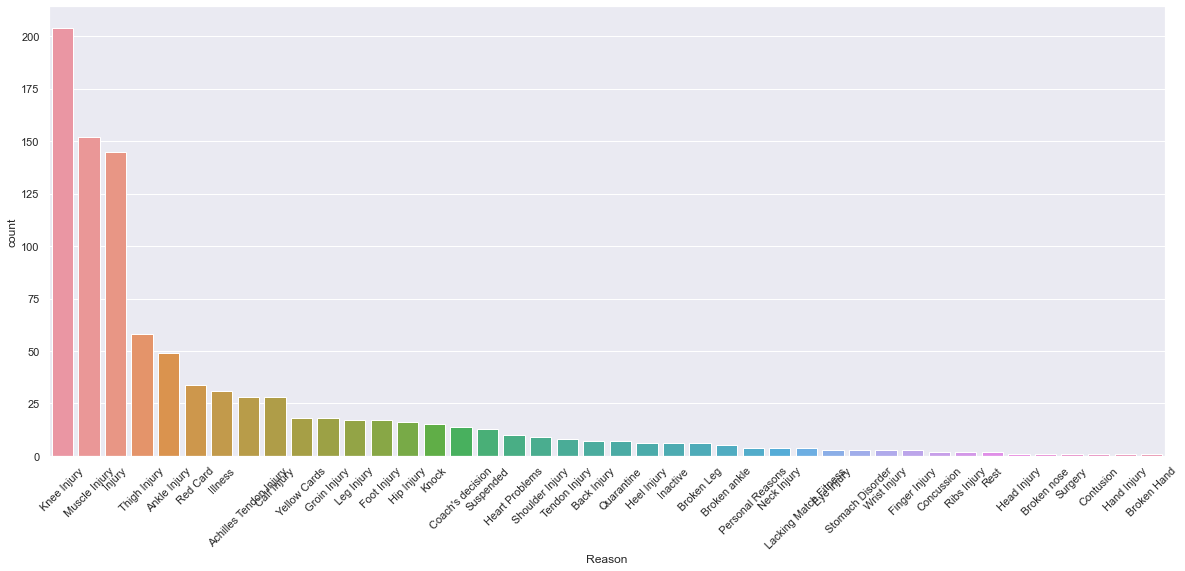

In [15]:
# get the most common reason for players injuries 
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
new = df_injuries
ax = sns.countplot(x="Reason", data=new, order = new['Reason'].value_counts().index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [16]:
# get the list of players with history of knee injury
df_new_player = df_injuries[(df_injuries['Reason'] == 'Knee Injury')]

In [17]:
df_new_player

,Player_ID,Player_Name,Injury_Type,Reason,Team_ID,Team,Date
0,51617,D. Nunez,Missing Fixture,Knee Injury,211,Benfica,2021-08-18T19:00:00+00:00
5,163184,M. Kreekels,Missing Fixture,Knee Injury,197,PSV Eindhoven,2021-08-18T19:00:00+00:00
6,102851,R. Ledezma,Missing Fixture,Knee Injury,197,PSV Eindhoven,2021-08-18T19:00:00+00:00
7,194645,S. Sambo,Missing Fixture,Knee Injury,197,PSV Eindhoven,2021-08-18T19:00:00+00:00
10,2732,J. Knudsen,Missing Fixture,Knee Injury,375,Malmo FF,2021-08-18T19:00:00+00:00
...,...,...,...,...,...,...,...
936,288,A. Moreno,Missing Fixture,Knee Injury,533,Villarreal,2022-03-16T20:00:00+00:00
938,2933,B. Chilwell,Missing Fixture,Knee Injury,49,Chelsea,2022-03-16T20:00:00+00:00
941,9991,Lucas Verissimo,Missing Fixture,Knee Injury,211,Benfica,2022-04-05T19:00:00+00:00
950,2933,B. Chilwell,Missing Fixture,Knee Injury,49,Chelsea,2022-04-06T19:00:00+00:00


In [18]:
# teams with most number of players prone to knee injury
df_new_player.value_counts('Team')

Team
Malmo FF                  23
Red Bull Salzburg         14
Borussia Dortmund         14
Barcelona                 13
VfL Wolfsburg             12
Dynamo Kyiv               10
Shakhtar Donetsk          10
RB Leipzig                10
AC Milan                   9
Ajax                       9
Juventus                   8
Benfica                    7
BSC Young Boys             6
Besiktas                   6
Bayern Munich              6
Chelsea                    5
Inter                      5
Paris Saint Germain        5
PSV Eindhoven              4
Atletico Madrid            4
Sporting CP                4
Zenit Saint Petersburg     4
FC Porto                   3
Villarreal                 3
Real Madrid                2
Lille                      2
Club Brugge KV             2
Monaco                     1
Manchester United          1
Manchester City            1
Brondby                    1
dtype: int64